## **Outline**

- [1 - Import library](#1)
- [2 - Data Wrangling](#2)
- [3 - Exploratory data analysis](#3)
    - [3.1 - Explore the variables](#3.1)
    - [3.2 - Explore product category](#3.2)
    - [3.3 - Explore customer category using K-Means Algorithm](#3.3)
- [4 - Classification Customer](#4)
    - [4.1 - Random forest](#4.1)
    - [4.2 - XGboost](#4.2)
    - [4.3 - Logistic Regression](#4.3)
    - [4.4 - Deep Neural Network](#4.4)
- [5 - Testing the predictions](#5)
- [6 - Summary](#6)

## **1 - Import library**

load all libraries need

In [336]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, warnings, nltk
import itertools
from pathlib import Path
from sklearn import preprocessing, model_selection, feature_selection, metrics
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, ensemble
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, confusion_matrix, accuracy_score 
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import tensorflow as tf
from IPython.display import display, HTML

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## **2 - Data Wrangling**

Data description:
- **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.
- **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
- **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name each customer.

source data: [e-commerce](https://www.kaggle.com/datasets/carrie1/ecommerce-data)

load the dataset and show some information from dataset like a number of a dataset, number variables/feature, data type, statistics descriptive, null/NA values, and duplicated value.

In [3]:
# import dataset
df_raw = pd.read_csv('data.csv', encoding="ISO-8859-1", dtype = {'InvoiceNo':str, 'CustomerID':str})

print('dataframe dimension: ', df_raw.shape)

dataframe dimension:  (541909, 8)


In [4]:
# dataset summary
df_raw.describe(include="all")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829,541909
unique,25900,4070,4223,NaN,23260,NaN,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,17841,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,7983,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,NaN,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,NaN,NaN


It can be seen that the dataset consists of 541909 data records and has 8 variables, in InvoiceNo the number of unique numbers totals 25900, meaning there are twin InvoiceNo, as well as StockCode, we also know that there are 38 countries, which means we can categorizing the number of purchases based on countries. But we know that InvoiceNo and CustomerID should not be integers so we will check the type of the variables

In [5]:
# check type variable
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


We will hange InvoiceDate to datetime.

In [6]:
# change data type
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


next, we will check NA value and count how many NA value in dataset, then we weill check duplicated data and will removed

In [7]:
# check NA value of dataset
df_raw.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
print("NA value of dataset: {}%".format(round(df_raw.CustomerID.isna().sum()/df_raw.shape[0]*100, 2)))

NA value of dataset: 24.93%


since the number of NA values for customers is ~25%, and we don't have any additional information to impute, we will remove it.

In [9]:
# remove NA value
df_raw.dropna(axis=0, subset=['CustomerID'], inplace=True)

print(df_raw.isna().sum())
print('dataframe dimension: ', df_raw.shape)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
dataframe dimension:  (406829, 8)


In [10]:
# show first 5 data
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


we will check if there are duplicate values and remove them.

In [11]:
# check duplicated value
df_raw.duplicated().sum()

5225

In [12]:
# remove duplicate value
df_raw.drop_duplicates(inplace=True)
print('dataframe dimension: ', df_raw.shape)

dataframe dimension:  (401604, 8)


In [13]:
# check summary again
df_raw.describe(include="all")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,401604,401604,401604,401604.000000,401604,401604.000000,401604,401604
unique,22190,3684,3896,NaN,NaN,NaN,4372,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,17841,United Kingdom
freq,542,2065,2058,NaN,NaN,NaN,7812,356728
mean,NaN,NaN,NaN,12.183273,2011-07-10 12:08:23.848567552,3.474064,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,0.000000,NaN,NaN
25%,NaN,NaN,NaN,2.000000,2011-04-06 15:02:00,1.250000,NaN,NaN
50%,NaN,NaN,NaN,5.000000,2011-07-29 15:40:00,1.950000,NaN,NaN
75%,NaN,NaN,NaN,12.000000,2011-10-20 11:58:30,3.750000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,NaN,NaN


## **3. Exploratory Data Analysis**

### **3.1 - Explore the variables**

#### Explore Customer ~ Product

In [14]:
# count number of user and product
pd.DataFrame([{
    'products': len(df_raw['StockCode'].value_counts()),
    'transactions': len(df_raw['InvoiceNo'].value_counts()),
    'customers': len(df_raw['CustomerID'].value_counts()),
}],
columns= ['products', 'transactions', 'customers'],
index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [15]:
# count the products purchased by each customer
temp = df_raw.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

num_product_per_cust = temp.rename(columns = {'InvoiceDate': 'Product Count'})
num_product_per_cust[:12].sort_values(by='CustomerID')

,CustomerID,InvoiceNo,Product Count
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


It can be seen that the customer with ID 12346 canceled the order with code **C541433**, so it is necessary to create a table to calculate the order cancellation for each transaction.

In [16]:

num_product_per_cust['OrderCanceled'] = num_product_per_cust['InvoiceNo'].apply(lambda x:int('C' in x)) 
display(num_product_per_cust[:5])

# count percentage of orders canceled
x1 = num_product_per_cust['OrderCanceled'].sum()
x2 = num_product_per_cust.shape[0]
print('Number of canceled order: {}/{} ({:.2f}%)'.format(x1, x2, x1/x2*100))

,CustomerID,InvoiceNo,Product Count,OrderCanceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of canceled order: 3654/22190 (16.47%)


The total canceled orders reached ~16% of course this is quite large so it is necessary to do an in-depth analysis, therefore try to see the canceled transaction section.

We got negative quantity for canceled orders, other than that, all variables are identical with other transaction except **InvoiceDate** and **Quantity**. Therefore, we will check if all the lines that are order cancellations are the same as entry **C541433** with positive quantity.

In [17]:
display(df_raw.sort_values('CustomerID')[:10])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland
14944,537626,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland
14945,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland
14946,537626,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland
14947,537626,22805,BLUE DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland
148285,549222,22376,AIRLINE BAG VINTAGE JET SET WHITE,4,2011-04-07 10:43:00,4.25,12347,Iceland


In [18]:
# make new dataframe to check hypotesis
df_cek_order = df_raw[df_raw['Quantity'] < 0][['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice']]

for index, col in df_cek_order.iterrows():
    if  df_raw[(df_raw['CustomerID'] == col[0]) & (df_raw['Quantity'] == -col[1]) & (df_raw['Description'] == col[2])].shape[0] == 0:
        print(df_cek_order.loc[index])
        print(20*'='+'>>'+' NOT VALID EACH NEGATIVE QTY == CANCEL')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
====================>> NOT VALID EACH NEGATIVE QTY == CANCEL


It turns out that negative quantity is not always a canceled order, because there is a **discount**. So it needs to be recheck **without including discounts**

In [19]:
# make new dataframe without Discount to check hypotesis
df_cek_order = df_raw[(df_raw['Quantity'] < 0) & (df_raw['Description'] != 'Discount')][['CustomerID', 
                                                                                            'Quantity', 
                                                                                            'StockCode', 
                                                                                            'Description', 
                                                                                            'UnitPrice']]

for index, col in df_cek_order.iterrows():
    if  df_raw[(df_raw['CustomerID'] == col[0]) & (df_raw['Quantity'] == -col[1]) & (df_raw['Description'] == col[2])].shape[0] == 0:
        print(df_cek_order.loc[index])
        print(20*'='+'>>'+' NOT VALID EACH NEGATIVE QTY == CANCEL')
        break

CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
====================>> NOT VALID EACH NEGATIVE QTY == CANCEL


After checking again, it turns out that there is a negative order without a previous purchase record, so it is not always a negative order that has a partner, because this dataset is limited in date, we will check whether there are orders that entered before December 2010.

In [20]:
# create new dataframe to make cleaned dataframe
df_cleaned = df_raw.copy(deep=True)
df_cleaned['QtyCanceled'] = 0

to_remove = [] ; doubtfull_entry = []

for index, col in df_raw.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == ['Discount']: continue
    df_test = df_raw[(df_raw['CustomerID'] == col['CustomerID']) &
                    (df_raw['StockCode'] == col['StockCode']) &
                    (df_raw['InvoiceDate'] < col['InvoiceDate']) &
                    (df_raw['Quantity'] > 0)
                    ].copy()
    if (df_test.shape[0] == 0):
        doubtfull_entry.append(index)
    
    # if cancelation WITH counterpart
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QtyCanceled'] = -col['Quantity']
        to_remove.append(index)
    
    # if various counterparts exist
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0, ascending=False, inplace=True)
        for i, value in df_test.iterrows():
            if value['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[index_order, 'QtyCanceled'] = -col['Quantity']
            to_remove.append(index)
            break

In [21]:
print("to_remove: {}".format(len(to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

to_remove: 7521
doubtfull_entry: 1303


Since the number of these entries is relatively small compared to the total dataset, and may complicate the analysis due to not knowing the previous order history and thus biasing the segmentation case, these entries will be removed.

In [22]:
df_cleaned.drop(to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis=0, inplace=True)

remove_entry = df_cleaned[(df_cleaned['Quantity'] < 0) &
                        (df_cleaned['StockCode'] != 'D')]
print('number of entries to delete = {}'.format(remove_entry.shape[0]))
remove_entry.head()

number of entries to delete = 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QtyCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [23]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QtyCanceled


the amount of cancellation is greater than the amount of purchase

#### Explore StockCode

In [24]:
# get the all codes in stock code
code_list = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
code_list

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [25]:
for code in code_list:
    print("{:<15} >> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            >> POSTAGE                       
C2              >> CARRIAGE                      
M               >> Manual                        
BANK CHARGES    >> Bank Charges                  
PADS            >> PADS TO MATCH ALL CUSHIONS    
DOT             >> DOTCOM POSTAGE                


#### Explore Countries

Text(0.5, 1.0, 'Total Order by Country')

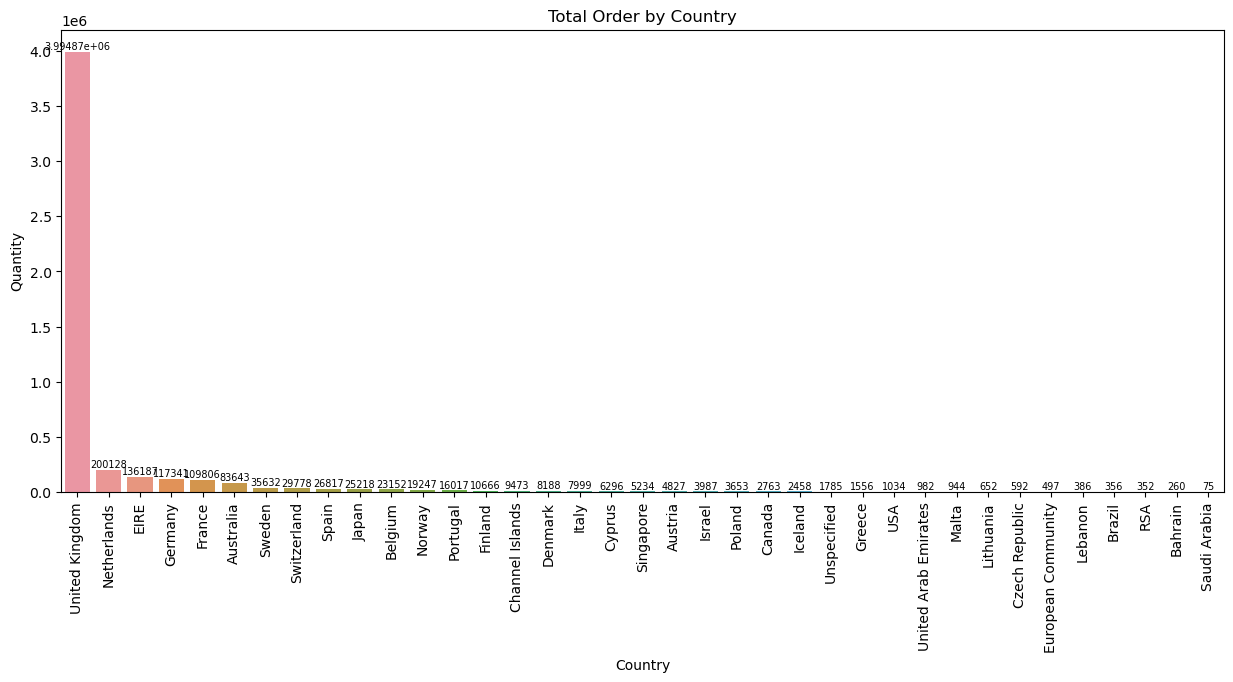

In [26]:
fig,ax = plt.subplots(figsize=(15,6))

sns.barplot(data=df_raw.groupby(by='Country').agg({
    'Quantity': 'sum'
    }).sort_values(by='Quantity', ascending=False).reset_index(), 
    x = 'Country', 
    y = 'Quantity',
    ax=ax
    )

plt.xticks(rotation=90)
ax.bar_label(ax.containers[0], fontsize=7)
plt.title('Total Order by Country')

UK is the country with the most orders

#### Explore Basket Price

In [27]:
# create Total Price column
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QtyCanceled'])
df_cleaned.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QtyCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7
428968,573511,47580,TEA TIME DES TEA COSY,6,2011-10-31 12:25:00,2.55,12347,Iceland,0,15.3
428967,573511,23173,REGENCY TEAPOT ROSES,2,2011-10-31 12:25:00,9.95,12347,Iceland,0,19.9


If we look closely, the same InvoiceNo with different product codes has different rows, therefore it is necessary to combine entries that have the same InvoiceNo to find out the total price.

In [28]:
# create dataframe basket price
df_temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
df_basket_price = df_temp.rename(columns= {'TotalPrice': 'Basket Price'})

# show a invoice date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
df_temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis=1, inplace=True)
df_basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(df_temp['InvoiceDate_int'])

# show updated basket price dataframe
df_basket_price = df_basket_price[df_basket_price['Basket Price'] > 0]
df_basket_price.sort_values('CustomerID').head(10)

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000000000
7,12347,581180,224.82,2011-12-07 15:52:00.000000000
8,12348,539318,892.80,2010-12-16 19:09:00.000000000
9,12348,541998,227.44,2011-01-25 10:42:00.000000000
10,12348,548955,367.00,2011-04-05 10:47:00.000000000


Since there are many variations of the total price, we will group them by creating categories based on the total price.

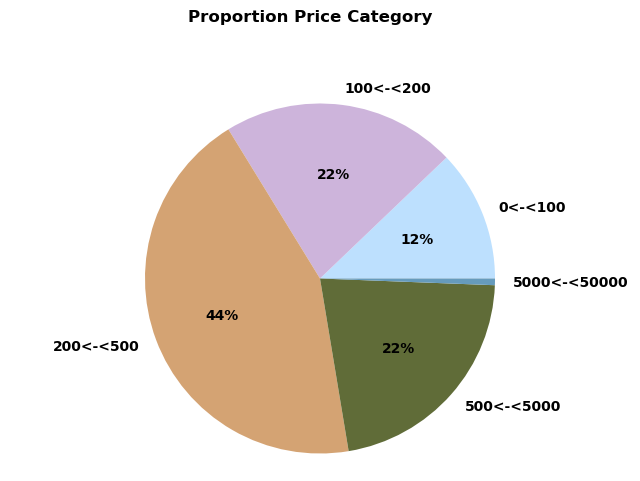

In [40]:
# make price category 
price_range = [0, 100, 200, 500, 5000, 50000]
price_count = []

for i, price in enumerate(price_range):
    if i == 0: continue
    val = df_basket_price[(df_basket_price['Basket Price'] < price) & (df_basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    price_count.append(val)

# plot price category
plt.rc('font', weight='bold')
fig,ax = plt.subplots(figsize=(8,5))

colors = ['#bde0fe', '#cdb4db', '#d4a373', '#606c38', '#669bbc']
labels  = ['{}<-<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes = price_count
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]

ax.pie(sizes,
        explode = explode,
        labels = labels,
        colors = colors,
        autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
        shadow = False,
        startangle = 0)
ax.axis('equal')
fig.text(0.5, 1.01, "Proportion Price Category", ha='center', fontsize = 12);


The majority of orders are relatively large, with the total price of more than £200 dominating. 

### **3.2 - Explore Product Category**

#### Explore Product Description

In [63]:
# extract description variable
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    stems = nltk.stem.SnowballStemmer("english")
    keywords_root = dict()
    keywords_select = dict()
    keyword_count = dict()
    category_keys = []
    icount = 0
    for i in dataframe[column]:
        if pd.isnull(i): continue
        lines = i.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for j in  nouns:
            j = j.lower() ; rac = stems.stem(j)
            if rac in keywords_root:
                keywords_root[rac].add(j)
                keyword_count[rac] += 1
            else:
                keywords_root[rac] = {j}
                keyword_count[rac] = 1
    
    for k in keywords_root.keys():
        if len(keywords_root[k]) > 1:
            min_len = 1000
            for l in keywords_root[k]:
                if len(l) < min_len:
                    clef = l ; min_len = len(l)
            
            category_keys.append(clef)
            keywords_select[k] = clef
        else:
            category_keys.append(list(keywords_root[k])[0])
            keywords_select[k] = list(keywords_root[k])[0]
    print("number of keyword in variable '{}': {}".format(column, len(category_keys)))
    return keywords_root, keywords_select, keyword_count, category_keys
            

In [67]:
# retrieve list of product
df_product = pd.DataFrame(df_raw['Description'].unique()).rename(columns = {0: 'Description'})

# analyze variable desc
keywords_root, keywords_select, keyword_count, keyword = keywords_inventory(df_product)

number of keyword in variable 'Description': 1483


In [69]:
#  convert the count_keywords dictionary into a list, to sort the keywords according to their occurences
list_product_keyword = []

keyword_count = dict(keyword_count)
for i, j in keyword_count.items():
    list_product_keyword.append([keywords_select[i], j])
list_product_keyword.sort(key=lambda x: x[1], reverse=True)

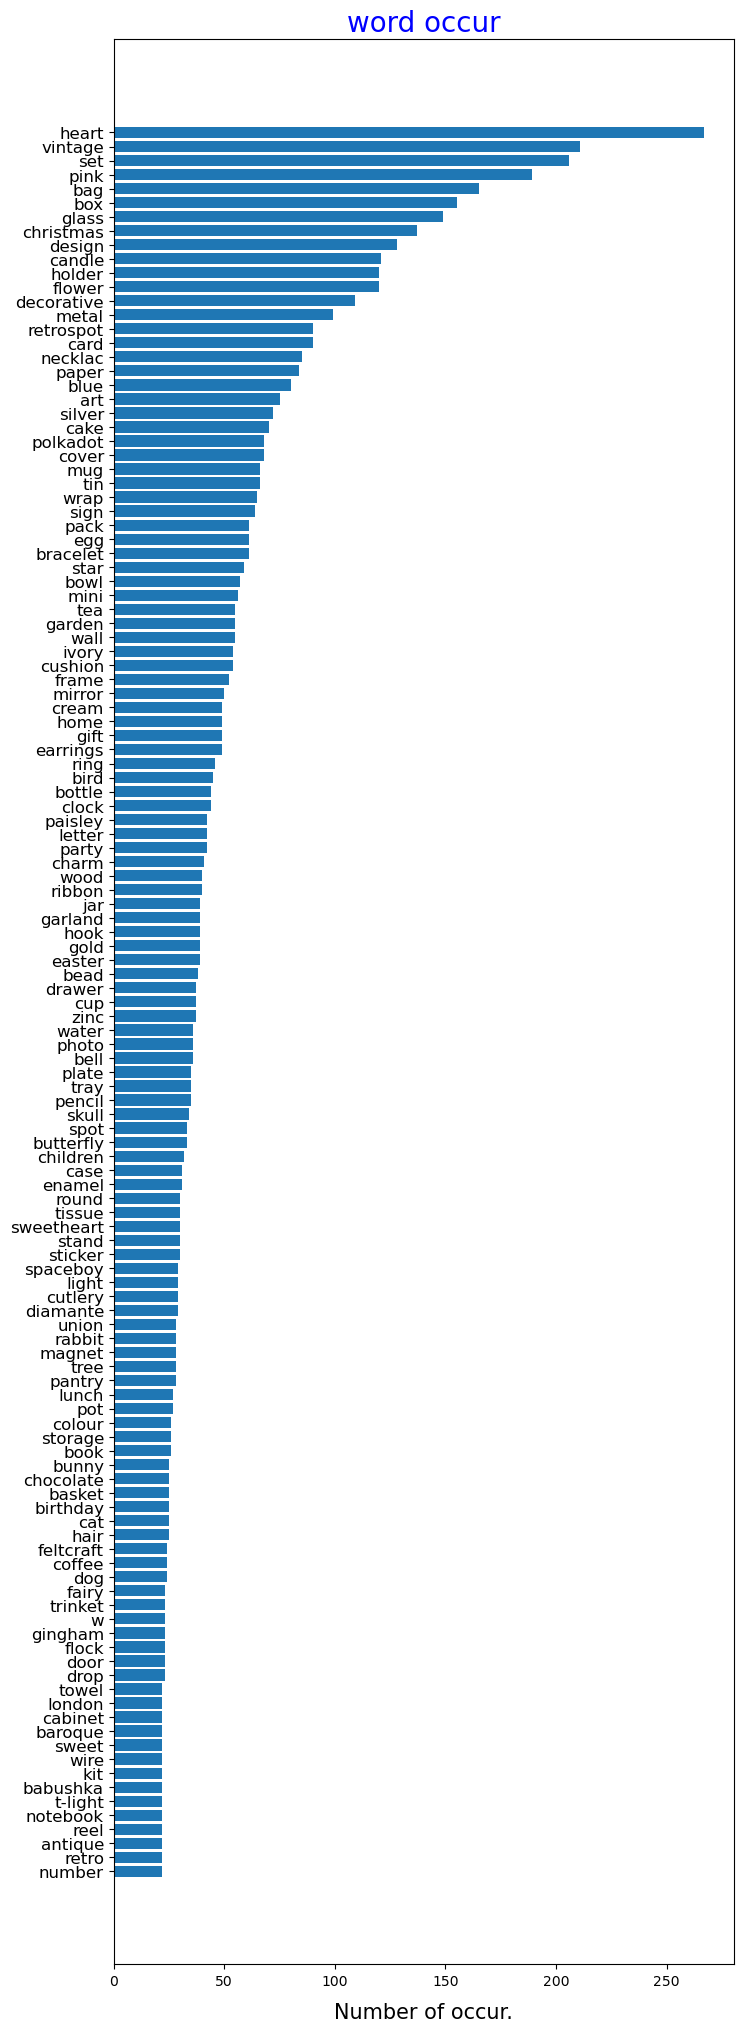

In [72]:
# plot keyword
listed = sorted(list_product_keyword, key=lambda x: x[1], reverse=True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(8,25))
y_axis = [i[1] for i in listed[:125]]
x_axis = [k for k, i in enumerate(listed[:125])]
x_label = [i[0] for i in listed[:125]]
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 12)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occur.", fontsize = 15, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("word occur", color = 'b', fontsize = 20)

plt.show()

out of 1483 keywords, there are keywords in the list that are less meaningful, so we will select words that appear only more than 15 times.

In [73]:
list_products = []

for i, j in keyword_count.items():
    word = keywords_select[i]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or j < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, j])

list_products.sort(key=lambda x: x[1], reverse=True)
print('number of keyword: {}'.format(len(list_products)))

number of keyword: 193


#### Data Encoding

I define the $X$ matrix where the  $a_{i,j}$ coefficient is 1 if the description of the product $i$ contains the word  $j$, and 0 otherwise

In [78]:
# encoding for keyword
list_products_encoding = df_cleaned['Description'].unique()
X = pd.DataFrame()

for m, n in list_products:
    X.loc[:, m] = list(map(lambda x: int(m.upper() in x), list_products_encoding))

X.head(3)

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


after hot encoding, it will be easier to group them based on how many keywords in each product come from the description variable, here we will try to select 6 groups and add these groups to a new column in matrix X.

In [80]:
threshold = [0, 1, 2, 3, 5, 10] # as the grouper
label_col = []

for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, j in enumerate(list_products_encoding):
    avg = df_cleaned[df_cleaned['Description'] == j]['UnitPrice'].mean()
    k = 0
    while avg > threshold[k]:
        k += 1
        if k == len(threshold): break
    X.loc[i, label_col[k-1]] = 1

In [82]:
# sum the total product per group
print("{} {} \n".format('range', 'number of products') + 20*'-')

for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
    print("{:<10} {:<20}".format(col, X.loc[:, col].sum()))

range number of products 
--------------------
0<.<1      964                 
1<.<2      1009                
2<.<3      673                 
3<.<5      606                 
5<.<10     470                 
.>10       155                 


In [86]:
X.head(3)

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,lace,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Clustering the Product

To create clusters, we will group them based on euclid distance, KMeans algorithm will be the best solution for now. The number of clusters will be seen from the sillhouette score or elbow graphs.

For number of clusters : 3 The average silhouette_score is : 0.0937107833188417
For number of clusters : 4 The average silhouette_score is : 0.12608617165656866
For number of clusters : 5 The average silhouette_score is : 0.1470050992526182
For number of clusters : 6 The average silhouette_score is : 0.14545067060589223
For number of clusters : 7 The average silhouette_score is : 0.14996518000200834
For number of clusters : 8 The average silhouette_score is : 0.1480936105209907
For number of clusters : 9 The average silhouette_score is : 0.14238537575816432


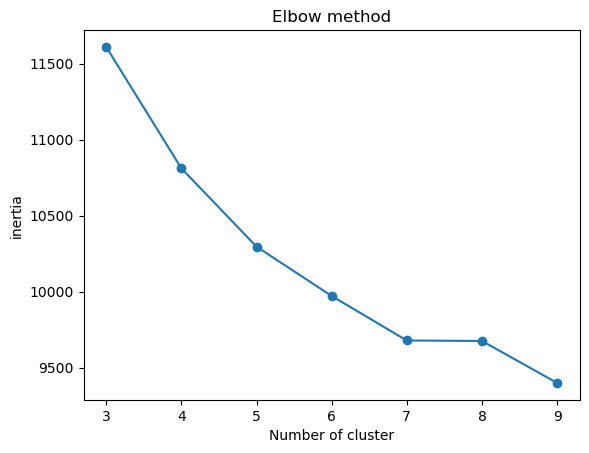

In [93]:
matriks = X.values
inertias = []

for n in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n, n_init=30)
    kmeans.fit(matriks)

    # silhouette score
    clusters = kmeans.predict(matriks)
    silhouette_avg = silhouette_score(matriks, clusters)
    print("For number of clusters :", n, "The average silhouette_score is :", silhouette_avg)

    # elbow graphs
    inertias.append(kmeans.inertia_)

plt.plot(range(3,10), inertias, marker = 'o')
plt.title('Elbow method')
plt.xlabel('Number of cluster')
plt.ylabel('inertia')
plt.show()

The silhouette score for n_clsuter > 3 does not show a significant difference, nor does the elbow graph clearly show the best number of clusters that can be selected. Therefore, we will try to select the largest silhouette score, n_cluster = 7, and then iterate whether it can achieve an avg of ~0.15.

In [95]:
n_cluster = 7
silhouette_avg = -1

while silhouette_avg < 0.149:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_cluster, n_init = 30)
    kmeans.fit(matriks)
    clusters = kmeans.predict(matriks)
    silhouette_avg = silhouette_score(matriks, clusters)

    print("For number of clusters :", n, "The average silhouette_score is :", silhouette_avg)

For number of clusters : 9 The average silhouette_score is : 0.14996518000200834


In [96]:
# number of point in every class
pd.Series(clusters).value_counts()

2    897
4    873
1    605
6    573
0    537
5    295
3     97
Name: count, dtype: int64

##### **Silhouette Score for Product Cat**

we will look at the silhouette score of each cluster to see how well the clustering is done.

In [104]:
def sil_each_cluster(n_clusters, lim_x, mat_size, sample_sil_val, cluster):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.rc('patch', edgecolor = 'dimgray', linewidth=1)

    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(5, 5)
    ax.set_xlim([lim_x[0], lim_x[1]])
    ax.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10

    for i in range(n_clusters):
        cluster_val = sample_sil_val[clusters == i]
        cluster_val.sort()
        size_cluster_i = cluster_val.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        
        ax.fill_betweenx(np.arange(y_lower, y_upper), 
                            0, 
                            cluster_val,
                            facecolor = color,
                            edgecolor = color,
                            alpha = 0.8)
        ax.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'b', fontweight = 'bold')
        y_lower = y_upper + 10
            

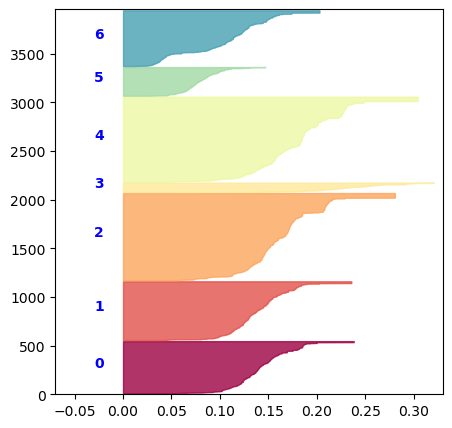

In [105]:
silhouette_val = silhouette_samples(matriks, clusters)

sil_each_cluster(n_cluster, [-0.07, 0.33], len(X), silhouette_val, clusters)

### **3.3 - Explore Customer Category**

#### Formatting Data

Next, I show the cluster of each product by inserting the product cluster obtained from the previous analysis into the dataframe by adding a new column ProductCategory. 

In [108]:
categ = dict()

for key, val in zip(list_products_encoding, clusters):
    categ[key] = val

df_cleaned['ProductCategory'] = df_cleaned.loc[:, 'Description'].map(categ)

Using this approach, each product description in the df_cleaned DataFrame is labeled with the appropriate cluster based on the clustering results previously performed.

In [118]:
# grouping product
for i in range(7):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['ProductCategory'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QtyCanceled'])
    price_temp = price_temp.apply(lambda x: x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace=True)

df_cleaned[['InvoiceNo', 'Description', 
            'ProductCategory', 'categ_0',
            'categ_1', 'categ_2', 'categ_3',
            'categ_4', 'categ_5', 'categ_6', 'InvoiceDate']].head(7)

,InvoiceNo,Description,ProductCategory,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,InvoiceDate
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,5,0.00,0.0,0.0,0.0,0.0,15.30,0.0,2010-12-01 08:26:00
1,536365,WHITE METAL LANTERN,0,20.34,0.0,0.0,0.0,0.0,0.00,0.0,2010-12-01 08:26:00
2,536365,CREAM CUPID HEARTS COAT HANGER,5,0.00,0.0,0.0,0.0,0.0,22.00,0.0,2010-12-01 08:26:00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34,0.0,0.0,0.0,0.0,0.00,0.0,2010-12-01 08:26:00
4,536365,RED WOOLLY HOTTIE WHITE HEART.,5,0.00,0.0,0.0,0.0,0.0,20.34,0.0,2010-12-01 08:26:00
5,536365,SET 7 BABUSHKA NESTING BOXES,6,0.00,0.0,0.0,0.0,0.0,0.00,15.3,2010-12-01 08:26:00
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,0,25.50,0.0,0.0,0.0,0.0,0.00,0.0,2010-12-01 08:26:00


Next, we will combine orders that have the same InvoiceNo to find out the total price on that InvoiceNo.

We will create it in a new dataframe using the basket price dataframe

In [126]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
df_basket_price = temp.rename(columns = {'TotalPrice': 'Basket Price'})

# sum the total price
for i in range(7):
    col = 'categ_{}'.format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)[col].sum()
    df_basket_price = pd.concat([df_basket_price, temp.iloc[:, 2:]], axis=1)

# formatting the date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
df_basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# filter basket price > 0
df_basket_price = df_basket_price[df_basket_price['Basket Price'] > 0]
df_basket_price.sort_values('CustomerID', ascending = True)[:7]


,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,InvoiceDate
1,12347,537626,711.79,270.85,83.40,167.4,22.5,23.40,19.80,124.44,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,151.50,35.40,118.0,47.9,55.90,28.44,38.25,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,115.00,35.70,311.1,35.4,70.80,30.00,38.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,168.76,78.06,74.4,0.0,21.00,20.40,19.90,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,158.16,119.70,83.3,0.0,48.10,39.60,136.05,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,368.72,424.20,163.7,0.0,120.70,84.90,132.10,2011-10-31 12:25:00.000000000
7,12347,581180,224.82,0.00,55.44,100.8,0.0,38.58,0.00,30.00,2011-12-07 15:52:00.000000000


#### Splitting Data

We wanted to create a model that could understand and predict customer behavior from their first visit to the site. To test this model we split the dataset into two parts: one to develop the model, which includes data from the first 10 months, and the other to test the model, which consists of data from the following two months.

In [127]:
print('min date:', df_basket_price['InvoiceDate'].min(), ';', 'max date: ', df_basket_price['InvoiceDate'].max())

min date: 2010-12-01 08:26:00 ; max date:  2011-12-09 12:50:00


In [129]:
# split data to data train and data test
data_train = df_basket_price[df_basket_price['InvoiceDate'] < datetime.datetime(2011,10,1)]
data_test = df_basket_price[df_basket_price['InvoiceDate'] >= datetime.datetime(2011,10,1)]

# copy independen data train
df_basket_price = data_train.copy(deep = True)

Next, we will summarize the transactions of each user including the number of orders, the lowest and highest total order price, the average order price, the total order price, and the percentage of the price spent by the user for each product category.

In [134]:
# create dataframe transaction per user
df_user_transaction = df_basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])
df_user_transaction.head()


,count,min,max,mean,sum
CustomerID,,,,,
12347,5,382.52,711.79,558.172000,2790.86
12348,4,227.44,892.80,449.310000,1797.24
12350,1,334.40,334.40,334.400000,334.40
12352,7,33.55,840.30,301.075714,2107.53
12353,1,89.00,89.00,89.000000,89.00


In [136]:
# make user spend percentage for each category
for i in range(7):
    col = 'categ_{}'.format(i)
    df_user_transaction.loc[:, col] = round((df_basket_price.groupby(by='CustomerID')[col].sum() / df_user_transaction['sum']*100), 2)

df_user_transaction.reset_index(drop = False, inplace = True)
df_basket_price.groupby(by='CustomerID')['categ_0'].sum()
df_user_transaction.sort_values('CustomerID', ascending=True)[:7]
    

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6
0,12347,5,382.52,711.79,558.172000,2790.86,30.97,12.62,27.02,3.79,7.85,4.95,12.79
1,12348,4,227.44,892.80,449.310000,1797.24,0.00,0.00,38.08,2.32,30.03,9.53,20.03
2,12350,1,334.40,334.40,334.400000,334.40,0.00,27.90,48.44,6.10,5.59,0.00,11.96
3,12352,7,33.55,840.30,301.075714,2107.53,14.76,2.52,10.63,0.70,0.48,4.44,66.46
4,12353,1,89.00,89.00,89.000000,89.00,0.00,19.89,13.03,0.00,0.00,0.00,67.08
5,12354,1,1079.40,1079.40,1079.400000,1079.40,10.97,7.74,23.35,28.92,10.23,1.61,17.17
6,12355,1,459.40,459.40,459.400000,459.40,25.27,11.56,53.29,0.00,0.00,0.00,9.88


Last step, we will create two new columns that contain how many days have passed since the user made the **first order** and the **last order**.

In [138]:
last_date = df_basket_price['InvoiceDate'].max().date()

first_order = pd.DataFrame(df_basket_price.groupby(by='CustomerID')['InvoiceDate'].min())
last_order = pd.DataFrame(df_basket_price.groupby(by='CustomerID')['InvoiceDate'].max())

days_first = first_order.applymap(lambda x: (last_date - x.date()).days)
days_last = last_order.applymap(lambda x: (last_date - x.date()).days)

df_user_transaction.loc[:, 'LastOrder'] = days_last.reset_index(drop=False)['InvoiceDate']
df_user_transaction.loc[:, 'FirstOrder'] = days_first.reset_index(drop=False)['InvoiceDate']

df_user_transaction.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,LastOrder,FirstOrder
0,12347,5,382.52,711.79,558.172000,2790.86,30.97,12.62,27.02,3.79,7.85,4.95,12.79,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,0.00,0.00,38.08,2.32,30.03,9.53,20.03,5,288
2,12350,1,334.40,334.40,334.400000,334.40,0.00,27.90,48.44,6.10,5.59,0.00,11.96,240,240
3,12352,7,33.55,840.30,301.075714,2107.53,14.76,2.52,10.63,0.70,0.48,4.44,66.46,2,226
4,12353,1,89.00,89.00,89.000000,89.00,0.00,19.89,13.03,0.00,0.00,0.00,67.08,134,134


We see that there are customers who only make 1 purchase, we will consider these customers as special case customers who need to be retained to make repeat orders. Before we classify them, let's first see how many customers made only one order

In [139]:
X1 = df_user_transaction[df_user_transaction['count'] == 1].shape[0]
X2 = df_user_transaction.shape[0]

print("number of user with only one times order: {}/{} ({:<2.2f})%".format(X1, X2, X1/X2*100))

number of user with only one times order: 1442/3606 (39.99)%


With this we know ~40% of the total orders are users who made only one order during the year. Of course this is a fairly large number, with this information we will create a classification model for users later.

#### Create Category of Customer

We will perform clustering using the created df_user_transaction. We will only use some of the integer variables in the table

In [141]:
list_col = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'categ_6']

df_select_cust = df_user_transaction.copy(deep=True)
matriks2 = df_select_cust[list_col].values

since the variables in this data have different variances, it would be better to standardize them to produce optimal clustering performance.

In [149]:
scaler = StandardScaler()
scaler.fit(matriks2)

print('variables mean values: \n' + 50*'=' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matriks2)

variables mean values: 
 [  3.63477537 257.75315641 569.66054437 379.71583555  13.77070438
  15.88861897  21.14463672   6.78252357  11.9571492   10.09700776
  20.92157793]


Next, we will use PCA (Principal Component Analysis) to reduce the dimensionality of the data by transforming it.

In [195]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

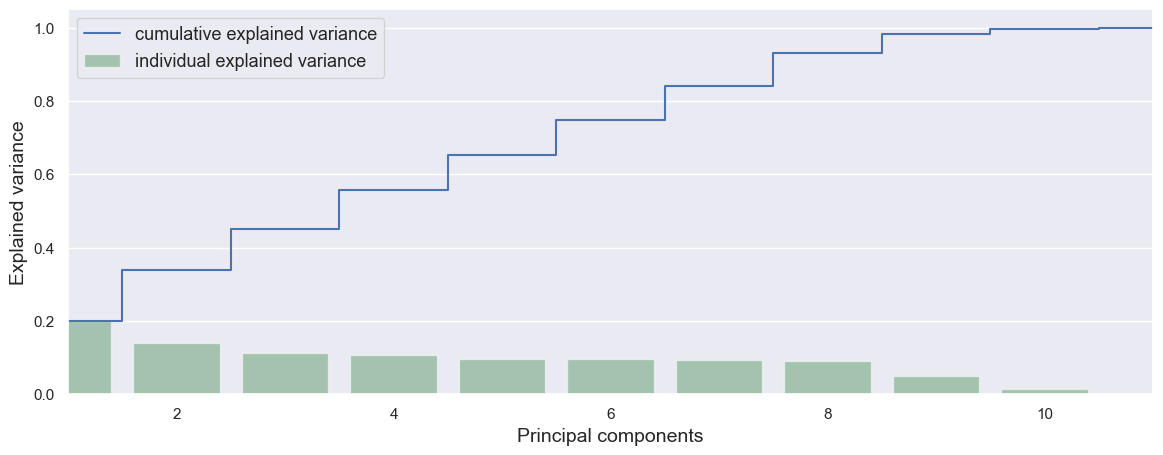

In [196]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matriks2.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
        label='cumulative explained variance')
sns.barplot(x=np.arange(1, matriks2.shape[1] + 1), y=pca.explained_variance_ratio_, alpha=0.5, color='g', 
        label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

After performing dimension reduction, we will perform clustering to place each user in the appropriate categories, with the KMeans algorithm we will use the silhouette score to determine the most optimal number of clusters.

For number of clusters : 3 The average silhouette_score is : 0.11881530280611742
For number of clusters : 4 The average silhouette_score is : 0.12495149525397674
For number of clusters : 5 The average silhouette_score is : 0.13427020422356933
For number of clusters : 6 The average silhouette_score is : 0.14603753701924038
For number of clusters : 7 The average silhouette_score is : 0.15278702749157122
For number of clusters : 8 The average silhouette_score is : 0.17165079104316602
For number of clusters : 9 The average silhouette_score is : 0.17880340618563415
For number of clusters : 10 The average silhouette_score is : 0.18870270822129728
For number of clusters : 11 The average silhouette_score is : 0.18371433750272087


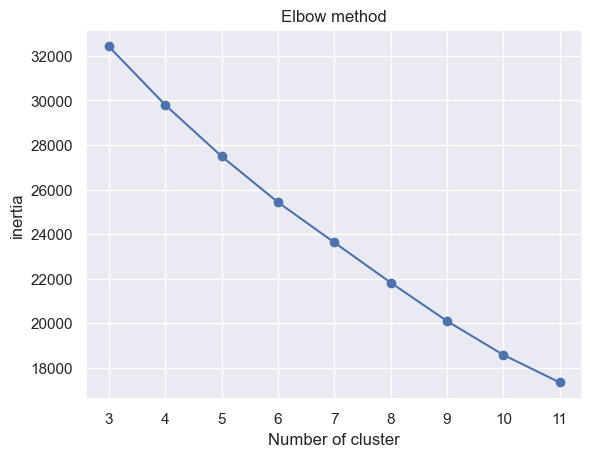

In [162]:
iner = []

for n in range(3,12):
    kmeans = KMeans(init='k-means++', n_clusters = n, n_init=100)
    kmeans.fit(scaled_matrix)

    # silhouette score
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    print("For number of clusters :", n, "The average silhouette_score is :", silhouette_avg)

    # elbow graphs
    iner.append(kmeans.inertia_)

plt.plot(range(3,12), iner, marker = 'o')
plt.title('Elbow method')
plt.xlabel('Number of cluster')
plt.ylabel('inertia')
plt.show()

From the results above, it is found that the best silhouette score is in the number of clusters 10, then we will use cluster 10 to categorize customers.

In [173]:
n_clusters = 10
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.18856375648245402


In [185]:
# show number of customer each cluster
pd.Series(clusters).value_counts()

2    1377
8     543
1     476
0     388
6     351
3     234
7     106
9      94
4      30
5       7
Name: count, dtype: int64

#### Cluster Validation Visualization

We will try to see the cluster differences in the visualization to validate whether there really are cluster differences. 

1. With PCA

In [206]:
pca_1 = PCA(n_components=4)
matriks_2D = pca_1.fit_transform(scaled_matrix)
matriks_pca = pd.DataFrame(matriks_2D)
matriks_pca['cluster'] = pd.Series(clusters)

In [207]:
matriks_pca.head()

,0,1,2,3,cluster
0,0.518206,0.028180,-0.018140,-0.116330,0
1,0.077025,-1.201860,-0.602925,1.594421,2
2,-0.008932,-1.433518,0.020421,-0.617932,2
3,-0.170874,2.348825,0.125342,0.840102,8
4,-0.747510,1.709454,-0.193664,-0.416269,8


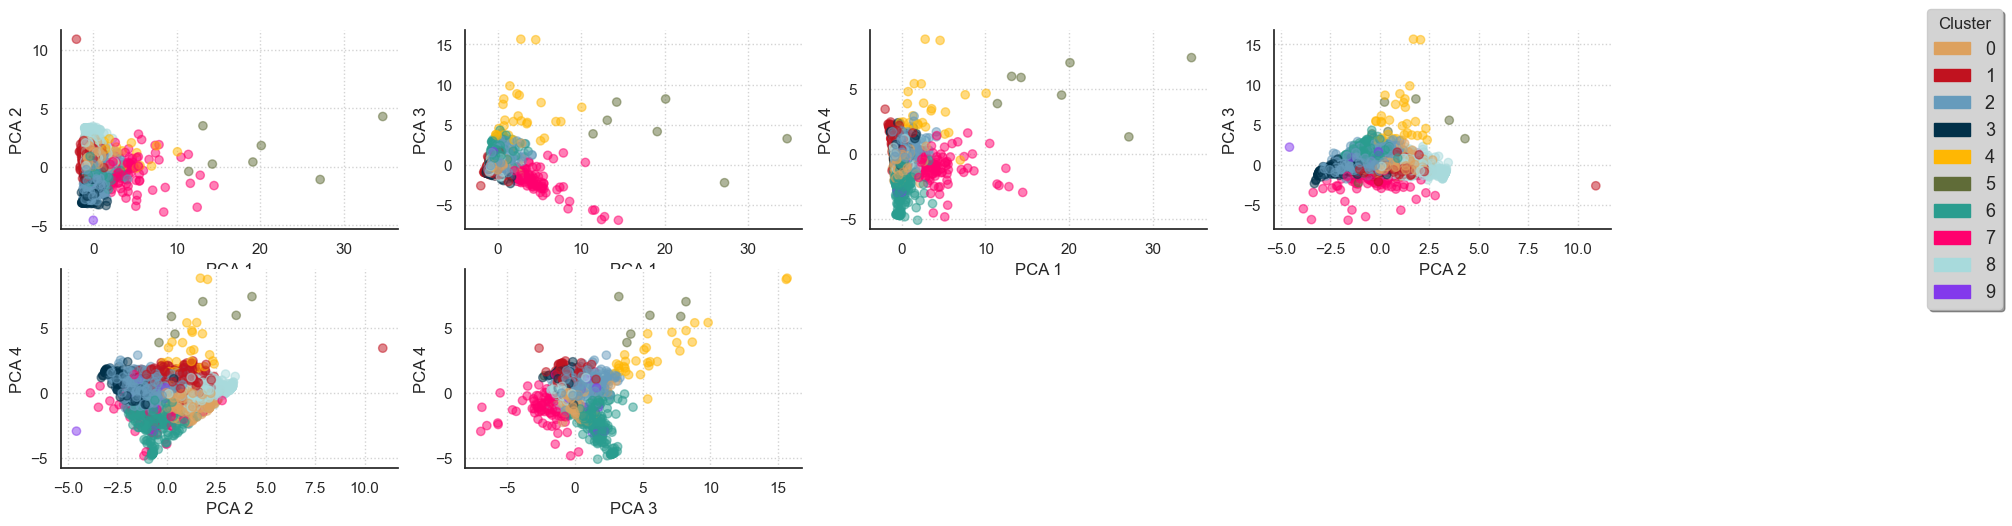

In [219]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.})

COLOR_MAP = {0:'#dda15e', 1:'#c1121f', 2:'#669bbc', 3:'#003049', 4:'#ffb703', 5:'#606c38', 6:'#2a9d8f', 7:'#ff006e', 8:'#a8dadc', 9:'#8338ec'}
label_color = [COLOR_MAP[i] for i in matriks_pca['cluster']]

fig = plt.figure(figsize=(20,15))
increment = 0

for i in range(4):
    for j in range(i+1, 4):
        increment += 1
        ax = fig.add_subplot(5, 4, increment)
        ax.scatter(matriks_pca[i], matriks_pca[j], c=label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(j+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(i+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 10: break
    if increment == 10: break

# create legend
label_legend = []

for i in range(n_clusters):
    label_legend.append(mpatches.Patch(color = COLOR_MAP[i], label = i))

plt.legend(handles=label_legend, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()


We can see by plotting for each of the 2 PCA matrices that there is a pattern of clustering.

## **4 - Classification Customer**

We will classify customers in different categories on their first visit, to be able to do this we will create a `class` to be used in several different classification algorithms.

In [222]:
class Fit_Model(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

This `class` aims to wrap a classification model (classifier) and provides methods to train the model, make predictions, and perform a grid search to find the best parameters.

In [227]:
# add column cluster to df_select_cust
df_select_cust.loc[:, 'cluster'] = clusters
df_select_cust.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,LastOrder,FirstOrder,cluster
0,12347,5,382.52,711.79,558.172000,2790.86,30.97,12.62,27.02,3.79,7.85,4.95,12.79,59,297,0
1,12348,4,227.44,892.80,449.310000,1797.24,0.00,0.00,38.08,2.32,30.03,9.53,20.03,5,288,2
2,12350,1,334.40,334.40,334.400000,334.40,0.00,27.90,48.44,6.10,5.59,0.00,11.96,240,240,2
3,12352,7,33.55,840.30,301.075714,2107.53,14.76,2.52,10.63,0.70,0.48,4.44,66.46,2,226,8
4,12353,1,89.00,89.00,89.000000,89.00,0.00,19.89,13.03,0.00,0.00,0.00,67.08,134,134,8


In [228]:
col = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'categ_6']

# create variable independen (X) and dependent (Y)
X = df_select_cust[col]
Y = df_select_cust['cluster']

Next, we will splitting data to data testing and data training using `train_test_split` function using X and Y dataframe

In [229]:
# split X, Y to data training 80% and data testing 20%
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.8)

#### **4.1 - Random Forest Algorithm**

Create Model Random Forest

In [300]:
RF = Fit_Model(clf=RandomForestClassifier)
param_rf = {'criterion': ['entropy', 'gini'], 
        'n_estimators': [29, 40, 60, 80, 100],
        'max_features' : ['sqrt', 'log2']}

RF.grid_search(parameters = param_rf, Kfold=5)
RF.grid_fit( X = X_train, Y = y_train)
RF.grid_predict( X = X_test, Y = y_test)

Precision: 92.66 % 


Learning Curve Random Forest

In [301]:
# create function for learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)

    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

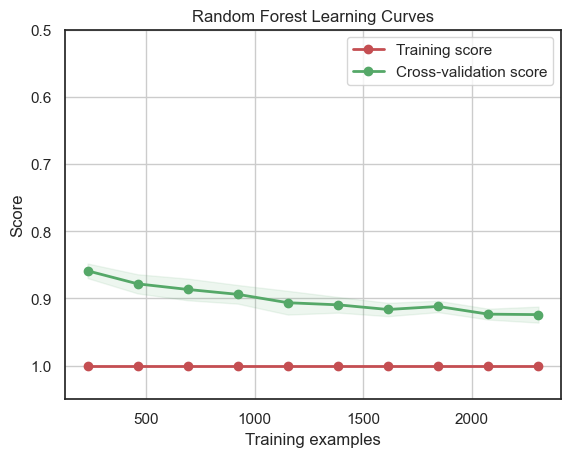

In [302]:
learn_curve_RF = plot_learning_curve(RF.grid.best_estimator_, 
                                "Random Forest Learning Curves",
                                X_train,
                                y_train,
                                ylim = [1.05, 0.5],
                                cv = 5)

#### **4.2 - XGboost Algorithm** 

Create Model XGboost

In [303]:
XGB = Fit_Model(clf=XGBClassifier)
param_xgb = {'learning_rate': [0.1], 
        'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'verbosity' : [1]}

XGB.grid_search(parameters = param_xgb, Kfold=5)
XGB.grid_fit( X = X_train, Y = y_train)
XGB.grid_predict( X = X_test, Y = y_test)

Precision: 91.14 % 


Learning Curve XGBoost

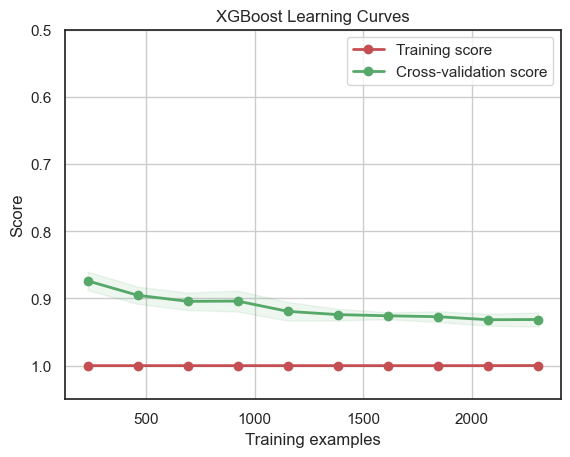

In [304]:
learn_curve_XGB = plot_learning_curve(XGB.grid.best_estimator_, 
                                "XGBoost Learning Curves",
                                X_train,
                                y_train,
                                ylim = [1.05, 0.5],
                                cv = 5)

### **4.3 - Logistic Regression Algorithm**

Create Model Logistic Reg.

In [250]:
LR = Fit_Model(clf=linear_model.LogisticRegression)

LR.grid_search(parameters =  [{'C': np.logspace(-2, 2, 20)}], Kfold = 5)
LR.grid_fit( X = X_train, Y = y_train)
LR.grid_predict( X = X_test, Y = y_test)

Precision: 94.88 % 


Learning Curve Logistic Regression

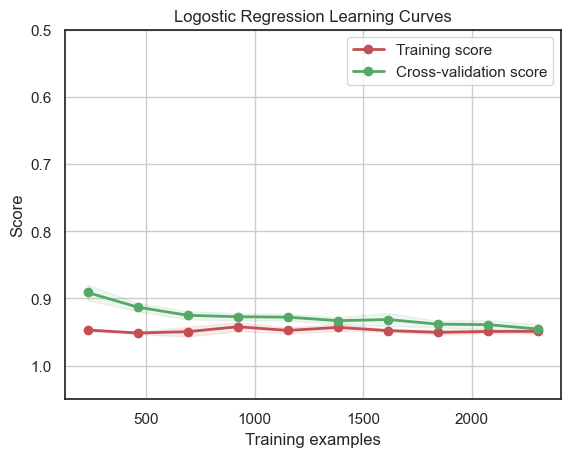

In [251]:
learn_curve_LR = plot_learning_curve(LR.grid.best_estimator_, 
                                "Logostic Regression Learning Curves",
                                X_train,
                                y_train,
                                ylim = [1.05, 0.5],
                                cv = 5)

### **4.4 - Deep Neural Network (DNN) Algorithm**

Create Model DNN

In [273]:
model = tf.keras.Sequential([
    keras.layers.Dense(units = 64, activation = 'relu', input_shape = (X_train.shape[1],), name = 'L1'),
    keras.layers.Dense(units = 32, activation = 'relu', name = 'L2'),
    keras.layers.Dense(units = 10, activation = 'linear', name = 'L3'),
    ])

model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            metrics = ['accuracy'])

In [274]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 64)                576       
                                                                 
 L2 (Dense)                  (None, 32)                2080      
                                                                 
 L3 (Dense)                  (None, 10)                330       
                                                                 
Total params: 2,986
Trainable params: 2,986
Non-trainable params: 0
_________________________________________________________________


In [275]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
73/73 [==============================] - 1s 8ms/step - loss: 5.7619 - accuracy: 0.3208 - val_loss: 1.8081 - val_accuracy: 0.5078
Epoch 2/50
73/73 [==============================] - 0s 3ms/step - loss: 1.1808 - accuracy: 0.6974 - val_loss: 0.7496 - val_accuracy: 0.7678
Epoch 3/50
73/73 [==============================] - 0s 3ms/step - loss: 1.0537 - accuracy: 0.7755 - val_loss: 0.7902 - val_accuracy: 0.7452
Epoch 4/50
73/73 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.8244 - val_loss: 0.6068 - val_accuracy: 0.8111
Epoch 5/50
73/73 [==============================] - 0s 3ms/step - loss: 0.8786 - accuracy: 0.8236 - val_loss: 0.4420 - val_accuracy: 0.8631
Epoch 6/50
73/73 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.8639 - val_loss: 0.3920 - val_accuracy: 0.8492
Epoch 7/50
73/73 [==============================] - 0s 3ms/step - loss: 0.8919 - accuracy: 0.8331 - val_loss: 0.7697 - val_accuracy: 0.8146
Epoch 8/50
73/73 [==

In [276]:
# make predictions
predictions = model.predict(X_test)
predictions = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, predictions)

print("Precision: {:.2f} % ".format(100*accuracy))

23/23 [==============================] - 0s 1ms/step
Precision: 93.49 % 


Learning Curve DNN

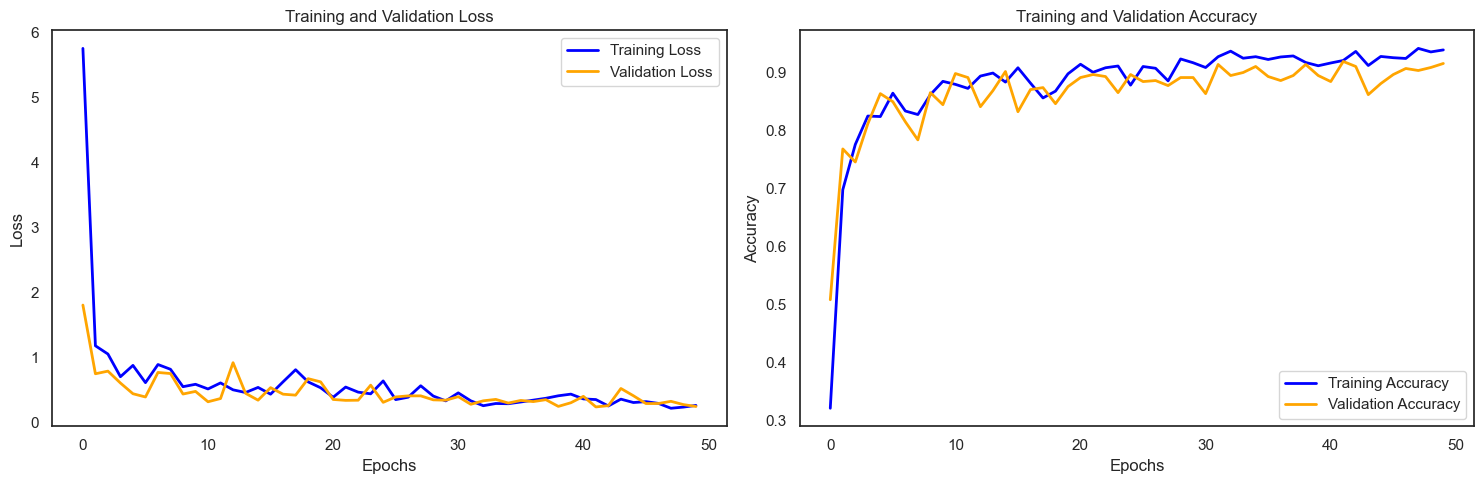

In [278]:
# Take the loss and accuracy from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axs[0].plot(train_loss, label='Training Loss', color='blue')
axs[0].plot(val_loss, label='Validation Loss', color='orange')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Accuracy
axs[1].plot(train_acc, label='Training Accuracy', color='blue')
axs[1].plot(val_acc, label='Validation Accuracy', color='orange')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


## **5 - Testing the Predictions**

Of the four algorithms, we produced good predictions with all accuracies above 90%. Now, We will combine ***Random Forest, XGBoost, and LogisticRegression*** algorithms by selecting the best parameters to improve the accuracy of the classification models. Then, we will **compare** it with the **ANN model** which is a Deep Learning model. We will use the best model for testing data.

In [337]:
# determining the best parameters
RF_best = RandomForestClassifier(**RF.grid.best_params_)
XGB_best = XGBClassifier(**XGB.grid.best_params_)
LR_best = linear_model.LogisticRegression(**LR.grid.best_params_)

# define models
list_models = [('Random Forest', RF_best),
                ('XGBoost', XGB_best),
                ('Logistic Regression', LR_best)]

In [342]:
# Define Classifier
voting_clf = VotingClassifier(estimators = list_models, voting = 'hard')
voting_clf = voting_clf.fit(X_train, y_train)

# Create prediction
accuracy_clf = voting_clf.score(X_test, y_test)

print("Accuracy of VotingClassifier: {:.2f} %".format(100*accuracy_clf))
print("Accuracy of Artificial Neural Network: {:.2f} % ".format(100*accuracy))


Accuracy of VotingClassifier: 92.52 %
Accuracy of Artificial Neural Network: 93.49 % 


Once we compare them, the ANN model has greater accuracy, although the difference between the Voting Classifier and ANN models is ~1%. Therefore, we will use the ANN model to perform the test. 

However, the Logistic Regression algorithm gets an accuracy of ~94% which is higher than all of them, therefore we will try all algorithms for testing data.

### **Testing Predictions**

we will test the models of the last two months of the dataset, which we have previously stored in the `set_test` dataframe:

In [343]:
df_basket_test = data_test.copy(deep=True)

In the first step, these data will be formatted like the data in set_test with a customized time range of the last 2 months.

In [369]:
# create df_user_transaction_test
df_user_transaction_test = df_basket_test.groupby(by='CustomerID')['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(7):
    col = 'categ_{}'.format(i)
    df_user_transaction_test.loc[:, col] = round((df_basket_test.groupby(by='CustomerID')[col].sum() / df_user_transaction_test['sum']*100), 2)

df_user_transaction_test.reset_index(drop=False, inplace=True)
df_basket_test.groupby(by='CustomerID')['categ_0'].sum()

# adjust the time
df_user_transaction_test['count'] = 5 * df_user_transaction_test['count']
df_user_transaction_test['sum'] = df_user_transaction_test['count'] * df_user_transaction_test['mean']
df_user_transaction_test.sort_values('CustomerID', ascending=True)[:10]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6
0,12347,10,224.82,1294.32,759.570,7595.70,24.27,31.57,17.41,0.00,10.48,5.59,10.67
1,12349,5,1757.55,1757.55,1757.550,8787.75,6.58,5.38,18.24,13.47,2.77,13.43,40.12
2,12352,5,311.73,311.73,311.730,1558.65,7.22,8.74,28.01,0.00,6.67,6.42,42.95
3,12356,5,58.35,58.35,58.350,291.75,0.00,0.00,0.00,56.30,0.00,0.00,43.70
4,12357,5,6207.67,6207.67,6207.670,31038.35,17.83,7.32,15.48,22.87,3.97,5.24,27.29
5,12358,5,683.20,683.20,683.200,3416.00,0.00,0.00,3.43,0.00,0.00,0.00,96.57
6,12359,5,2685.50,2685.50,2685.500,13427.50,24.30,11.04,11.80,0.77,0.38,3.84,47.88
7,12360,5,1043.78,1043.78,1043.780,5218.90,9.71,25.48,17.28,14.80,11.90,0.00,20.84
8,12362,25,355.80,786.95,520.008,13000.20,23.82,20.24,18.45,9.25,3.89,1.30,23.04
9,12364,10,299.06,310.32,304.690,3046.90,0.00,2.90,18.98,4.22,54.54,6.60,12.75


In the second step, we will do the same as when clustering the test data by selecting only certain numeric columns and then perform data normalization on this data testing.

In [371]:
list_col_test = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'categ_6']

matrix_cust_test = df_user_transaction_test[list_col_test].values
scaled_test_matrix = scaler.transform(matrix_cust_test)

At this step, the objective is to prepare test data by assigning categories to customers using data over a two-month period (using count, min, max, and sum variables). 

The goal is to use the data collected over a two-month period to assign customer categories. After that, the classifier can be tested by comparing its predictions with the predefined categories. The prediction method of this example will calculate the distance between the consumer and the centroid of the 10 client classes, and the consumer will be classified into the category that has the closest distance.

In [425]:
Y_set_test = kmeans.predict(scaled_test_matrix)

In [409]:
# choose variable to classifier
list_col_test = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'categ_6']

X_set_test = df_user_transaction_test[list_col_test]

In [410]:
X_set_test.head(5)

,mean,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6
0,759.57,24.27,31.57,17.41,0.00,10.48,5.59,10.67
1,1757.55,6.58,5.38,18.24,13.47,2.77,13.43,40.12
2,311.73,7.22,8.74,28.01,0.00,6.67,6.42,42.95
3,58.35,0.00,0.00,0.00,56.30,0.00,0.00,43.70
4,6207.67,17.83,7.32,15.48,22.87,3.97,5.24,27.29


### **Predict with DNN**

Next we will predict with Artificial Neural Network which is the best algorithm for this case.

In [417]:
model_test = tf.keras.Sequential([
    keras.layers.Dense(units = 64, activation = 'relu', input_shape = (X_set_test.shape[1],), name = 'L1'),
    keras.layers.Dense(units = 32, activation = 'relu', name = 'L2'),
    keras.layers.Dense(units = 10, activation = 'linear', name = 'L3'),
    ])

model_test.compile(optimizer = tf.keras.optimizers.Adam(0.001),
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            metrics = ['accuracy'])

In [418]:
model_test.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 64)                576       
                                                                 
 L2 (Dense)                  (None, 32)                2080      
                                                                 
 L3 (Dense)                  (None, 10)                330       
                                                                 
Total params: 2,986
Trainable params: 2,986
Non-trainable params: 0
_________________________________________________________________


In [421]:
history_test = model_test.fit(X_set_test, Y_set_test, epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
64/64 [==============================] - 2s 7ms/step - loss: 27.9505 - accuracy: 0.2044 - val_loss: 6.0011 - val_accuracy: 0.1387
Epoch 2/50
64/64 [==============================] - 0s 3ms/step - loss: 4.0798 - accuracy: 0.4289 - val_loss: 5.1085 - val_accuracy: 0.5078
Epoch 3/50
64/64 [==============================] - 0s 3ms/step - loss: 3.1672 - accuracy: 0.6396 - val_loss: 1.0687 - val_accuracy: 0.7520
Epoch 4/50
64/64 [==============================] - 0s 3ms/step - loss: 3.1876 - accuracy: 0.7100 - val_loss: 2.4677 - val_accuracy: 0.6582
Epoch 5/50
64/64 [==============================] - 0s 3ms/step - loss: 3.6107 - accuracy: 0.7017 - val_loss: 5.6581 - val_accuracy: 0.6523
Epoch 6/50
64/64 [==============================] - 0s 3ms/step - loss: 3.1839 - accuracy: 0.7281 - val_loss: 0.7759 - val_accuracy: 0.7754
Epoch 7/50
64/64 [==============================] - 0s 3ms/step - loss: 0.7365 - accuracy: 0.8108 - val_loss: 0.7043 - val_accuracy: 0.7656
Epoch 8/50
64/64 [=

In [429]:
# make predictions
predictions_test = model.predict(X_set_test)
predictions_test = np.argmax(model.predict(X_set_test), axis=1)
accuracy = accuracy_score(Y_set_test, predictions_test)

print("Precision: {:.2f} % ".format(100*accuracy))

80/80 [==============================] - 0s 1ms/step
Precision: 87.92 % 


### **Predict with RF, XGB, and LR**

In [422]:
# algoritma machine learning
classifiers_ML = [(RF, 'Random Forest'),
                (XGB, 'XGBoost'),
                (LR, 'Logostic Regression')]

# predict model
for clf, label in classifiers_ML:
    print(30*'=', '\n{}'.format(label))
    clf.grid_predict(X_set_test, Y_set_test)

Random Forest
Precision: 87.09 % 
XGBoost
Precision: 88.31 % 
Logostic Regression
Precision: 88.66 % 


We will combine the classifications of these algorithms again to improve the classification quality.

### **Predict with Voting Classifier**

In [423]:
predictions_clf_test = voting_clf.predict(X_set_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_set_test, predictions_clf_test)))

Precision: 88.82 % 


## **6 - Summary**

From the results of our tests, the best model is the Voting Classifier which combines models from 3 algorithms namely Random Forest, XGBoost, and Logistic Regression.

Overall, this dataset has features that can be explored more deeply, and the use of other models can also be applied to this case. The limitation of this dataset is that the time span is only one year, so it is not possible to perform time series analysis for forecasting.

We have clustered the products into 7 clusters using the Unsupervised Learning algorithm KMeans, and using KMeans we have also categorized the customers into 10 clusters. After clustering we do classification to see how suitable the given category is for each customer.

Classification is done in the last 2 months, the algorithm made successfully classifies correctly ~88% of the given class, this is a relatively high and good number and does not cause overfiting or underfiting.